In [1]:
import sys
sys.path.append('.../code')

import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
from hdqr import reg_conquer
import scipy.stats as spstat
import time

def check(x, tau):
    return np.mean(x*(tau-(x<0)))

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

The reference machine used for the simulations below is an iMac with a 4.2 GHz Quad-Core Intel i7 processor and 16 GB of RAM. Each simulation exploits only one processor, without any parallelism.

### Bootstrap methods for constructing confidence intervals for regression coefficients

In [2]:
n = 256
p = 1028
s = 8
tau = 0.8
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
beta = np.zeros(p)
beta[:21] = [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, -1, 0, 0, -1]
true_set = np.where(beta!=0)[0]
print('true model:', true_set+1)

true model: [ 1  3  6  9 12 15 18 21]


In [3]:
ci_cover, ci_width = np.zeros([3, p]), np.zeros([3, p])
M = 100
# true and false positives
tp, fp = np.zeros(M), np.zeros(M)
mb_tp, mb_fp = np.zeros(M), np.zeros(M)

runtime = 0
for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = 4 + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    reg_sqr = reg_conquer(X, Y, intercept=True)
    lambda_sim = np.quantile(reg_sqr.self_tuning(tau), 0.9)

    tic = time.time()  
    mb_beta, mb_fit = reg_sqr.boot_inference(Lambda=0.7*lambda_sim, tau=tau, weight="Multinomial")
    runtime += time.time() - tic
    mb_ci = mb_fit[0]
    
    est_set = np.where(mb_beta[1:,0]!=0)[0]
    mb_set = mb_fit[1]
    tp[m] =  len(np.intersect1d(true_set, est_set))
    fp[m] = len(np.setdiff1d(est_set, true_set))
    mb_tp[m] = len(np.intersect1d(true_set, mb_set))
    mb_fp[m] = len(np.setdiff1d(mb_set, true_set))
    
    for c in range(3):
        ci_cover[c,:] += 1*(beta >= mb_ci[c,1:,0])*(beta<= mb_ci[c,1:,1])
        ci_width[c,:] += mb_ci[c,1:,1] - mb_ci[c,1:,0]

In [4]:
ave_cover, ave_width = ci_cover/M, ci_width/M
cover = pd.DataFrame(np.concatenate([ave_cover.T, beta[:,None]], axis=1), columns=['percentile', 'pivotal', 'normal','true beta'])
width = pd.DataFrame(np.concatenate([ave_width.T, beta[:,None]], axis=1), columns=['percentile', 'pivotal', 'normal','true beta'])

boot_out = pd.concat([width.iloc[true_set,:3], cover.iloc[true_set,:3]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out,
      '\ntrue model:',      true_set+1,
      '\naverage runtime:', runtime/M,
      '\ntrue positive:',   np.mean(tp), 
      '\nfalse positive:',  np.mean(fp),
      '\nVSC prob:',        np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:',  np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nVSC prob after boot:',  np.mean((mb_tp==8)*(mb_fp==0)))
# VSC: variable selection consistency

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.344921  0.344921  0.348487        0.99     0.96    0.98
3     0.293706  0.293706  0.295289        0.99     0.97    0.98
6     0.357375  0.357375  0.360082        0.98     0.94    0.98
9     0.347977  0.347977  0.349242        0.97     0.89    0.96
12    0.365861  0.365861  0.368456        0.97     0.91    0.93
15    0.302625  0.302625  0.303047        0.97     0.91    0.95
18    0.471572  0.471572  0.475220        0.98     0.90    0.95
21    0.304087  0.304087  0.306140        0.97     0.93    0.98 
true model: [ 1  3  6  9 12 15 18 21] 
average runtime: 61.1424446105957 
true positive: 8.0 
false positive: 1.23 
VSC prob: 0.33 
true pos after boot: 8.0 
false pos after boot: 0.04 
VSC prob after boot: 0.96


Text(0.5, 1.0, 'Histogram of False Positives')

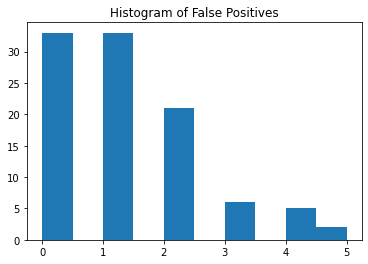

In [5]:
fig1 = plt.hist(fp)
plt.title(r'Histogram of False Positives')

Text(0.5, 1.0, 'Histogram of False Positives after Bootstrap')

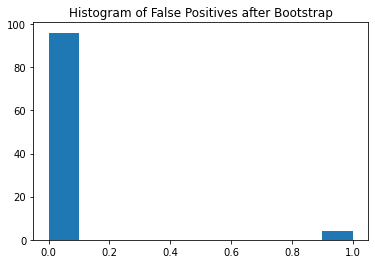

In [6]:
fig2 = plt.hist(mb_fp)
plt.title(r'Histogram of False Positives after Bootstrap')